In [1]:

import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
import time
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold._t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
RS = 20150101
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
# Fashion MNIST reader
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
x_train, y_train = load_mnist('data\\', kind='train')
print('Extraction completed!')

Extraction completed!


In [4]:
x_subset = x_train[0:2500]
y_subset = y_train[0:2500]
print(np.unique(y_subset))
time_start = time.time()
pca_64 = PCA(n_components=64)
pca_result_64 = pca_64.fit_transform(x_subset)
print('PCA with 64 components done! Time elapsed: {} seconds'.format(time.time()-time_start))
print('Cumulative variance explained by 50 principal components: {}'.format(np.sum(pca_64.explained_variance_ratio_)))

[0 1 2 3 4 5 6 7 8 9]
PCA with 64 components done! Time elapsed: 0.308643102645874 seconds
Cumulative variance explained by 50 principal components: 0.8897019026781301


In [5]:
x_final = pca_result_64/255
x_final.shape

(2500, 64)

In [6]:
# We first reorder the data points according to the handwritten numbers.
X_axis = np.vstack([x_final[y_subset==i]
               for i in range(10)])
Y_axis = np.hstack([y_subset[y_subset==i]
               for i in range(10)])

In [7]:
digits_proj = TSNE(random_state=RS, verbose=True, n_iter= 1000).fit_transform(X_axis)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 1.894896
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.866501
[t-SNE] KL divergence after 1000 iterations: 0.959383


In [39]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(10, 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(digits_proj[:,0], digits_proj[:,1], lw=0, s=5,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-0.05, 0.05)
    plt.ylim(--0.05, 0.05)
    ax.axis('off')
    ax.axis('tight')
    ax.autoscale(enable=True, axis='x', tight=True)

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

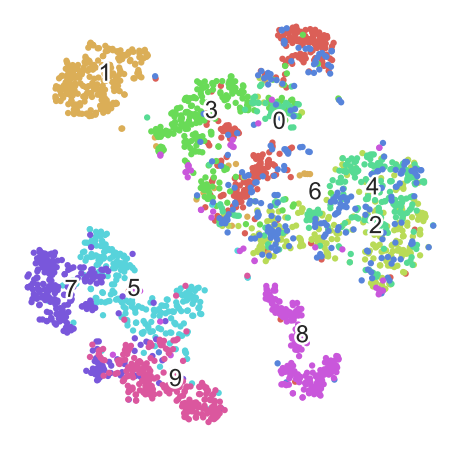

In [9]:
scatter(digits_proj, Y_axis)
plt.savefig('images/fashion_tsne-generated.png', dpi=120)

In [10]:
positions = []
def _gradient_descent(
    objective,
    p0,
    it,
    n_iter,
    n_iter_check=1,
    n_iter_without_progress=300,
    momentum=0.8,
    learning_rate=200.0,
    min_gain=0.01,
    min_grad_norm=1e-7,
    verbose=0,
    args=None,
    kwargs=None,
):

    print('This is the monkey patch version.')
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(float).max
    best_error = np.finfo(float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):

        positions.append(p.copy())

        check_convergence = (i + 1) % n_iter_check == 0
        # only compute the error when needed
        kwargs["compute_error"] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print(
                    "[t-SNE] Iteration %d: error = %.7f,"
                    " gradient norm = %.7f"
                    " (%s iterations in %0.3fs)"
                    % (i + 1, error, grad_norm, n_iter_check, duration)
                )

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print(
                        "[t-SNE] Iteration %d: did not make any progress "
                        "during the last %d episodes. Finished."
                        % (i + 1, n_iter_without_progress)
                    )
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print(
                        "[t-SNE] Iteration %d: gradient norm %f. Finished."
                        % (i + 1, grad_norm)
                    )
                break

    return p, error, i
sklearn.manifold._t_sne._gradient_descent = _gradient_descent

In [11]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, n_iter_without_progress=30,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=[], n_iter_check=1, kwargs=None):
    # The documentation of this function can be found in scikit-learn's code.

    print('This is the monkey patch version simple.')
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i
sklearn.manifold._t_sne._gradient_descent = _gradient_descent

In [12]:
import warnings
from time import time
import numpy as np
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse

In [31]:
X_proj = TSNE(random_state=RS,verbose=True,early_exaggeration= 200).fit_transform(X_axis)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.000s...
[t-SNE] Computed neighbors for 2500 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 1.894896
This is the monkey patch version simple.
[t-SNE] KL divergence after 250 iterations with early exaggeration: 2147.698486
This is the monkey patch version simple.
[t-SNE] KL divergence after 1000 iterations: 5.117597


In [14]:
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

In [15]:
X_iter.shape

(2500, 2, 1000)

MoviePy - Building file images/fashion_mnist.gif with imageio.


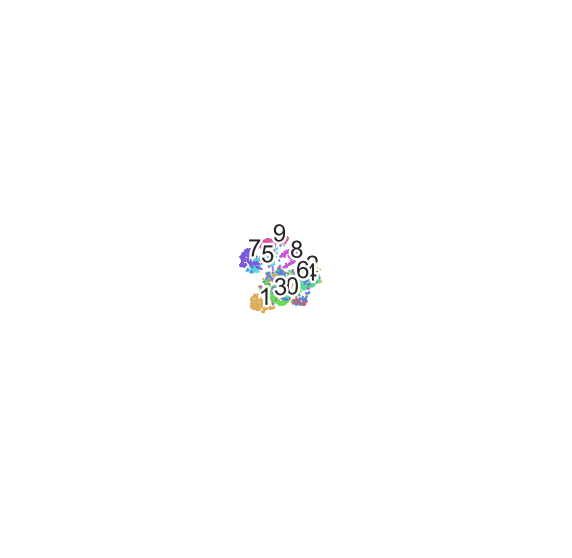

In [41]:
f, ax, sc, txts = scatter(X_iter[..., -1], Y_axis)

def make_frame_mpl(t):
    i = int(t*40)
    x_ani = X_iter[..., i]
    sc.set_offsets(x_ani)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x_ani[Y_axis == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("images/fashion_mnist.gif", fps=20)

In [ ]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none')
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("images/matrix1.gif", fps=20)